## Post-optimization operations

By loading optimized (hyper)parameters and weights, the confusion matrices can be here obtained, together with memory and energy evaluations.

#### <b>IMPORTANT NOTES:</b>
<b>1)</b> for each network,  the <b>optim_nni_experiment</b> variable must be set accordingly to the IDs of the NNI optimization experiment whose results are to be used;<br>
<b>2)</b> in the case of the sCNN, such variable is used to keep the optimized structure parameters as for the <i>NON-SPIKING</i> counterpart. The NNI optimization experiment ID for the spiking CNN must be set through the variables <b>snn_nni_experiment</b>.

<b>Hyperlinks to each network:</b><br>
<b>[LSTM](#Section_1)</b><br>
<b>[CNN](#Section_2)</b><br>
<b>[sCNN](#Section_3)</b><br>
<b>[LMU](#Section_4)</b><br>
<b>[sLMU](#Section_5)</b><br>
<b>[LMU (ff)](#Section_6)</b><br>
<b>[sLMU (ff)](#Section_7)</b><br>
[FLOPs calculation and energy estimation for LMU and LMU (ff)](#Section_8)<br>

### Install packages and download needed folders

In [ ]:
! pip install gdown==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=ddf59ae163d1d13216fedd3d1cfe6e6316035649ae35c326709c0f2efdae340a
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import os
import zipfile
import sqlite3

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_link = "https://drive.google.com/drive/folders/1iJQcdQ_Q0sIwQOtSS8hkWGTCN5Km4t1W"

In [ ]:
%%capture
if "NNI" not in os.listdir("./"):
  ! gdown $folder_link -O ./NNI --folder

In [ ]:
cd /content/drive/MyDrive/Project/NNI

/content/drive/.shortcut-targets-by-id/1T6FJpkctCqYwsEyKqCHvg29DYOd3H-KH/Project/NNI


In [ ]:
%%capture
! pip install -r ./requirements_pip.txt

In [ ]:
! pip uninstall numpy -y
! pip install numpy==1.19

Found existing installation: numpy 1.19.5
Uninstalling numpy-1.19.5:
  Successfully uninstalled numpy-1.19.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 13.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.19.0 which is incompatible.
jaxlib 0.3.22+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
jax 0.3.23 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.19.0 which is incompatible.
cmdstanpy 1.0.7 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.


In [ ]:
from postopt import *

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
print(device_name)

#### Functions for SOPs evaluation

In [ ]:
def get_sops_LMUens(net, freqdec=False):
    
    with net:
        lmu_inner.add_neuron_output()
        p_spikes = nengo.Probe(lmu_inner.neuron_output, label="p_spikes")
        net.config[p_spikes].keep_history = True
    
    with nengo_dl.Simulator(net) as sim:

        ### LOAD THE PRE-TRAINED WEIGHTS ###
        #local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
        local_output_folder = "/content/drive/MyDrive/Project/evaluations/Experiment_{}_{}".format(net_type,optim_nni_experiment)

        for ii in os.listdir(local_output_folder):
          if "output" in ii:
            target = ii

        zf = zipfile.ZipFile(local_output_folder+"/"+target)
        zf.extractall()

        sim.load_params("./output/tmp_{}_{}_{}/best_test_{}".format(net_type,correct_optim_nni_experiment,dataset_name,correct_optim_nni_experiment))
        ###
        
        sops = []
        accs = []
        
        dt = 0.001 # the default value in Nengo
    
        print("LEN")
        l = 0.1*len(x_test)
        print(l)
        #for ii in range(int(0.1*len(x_test))):
        for ii in range(int(0.02*len(x_test))):
            
            simulation_steps = int(len(x_test[ii]))
    
            sim.run_steps(simulation_steps, data={inp: x_test[ii][np.newaxis,:,:]})
    
        spikes = sim.data[p_spikes]/amplitude*dt
        spikes_per_neuron = np.sum(spikes > 0, axis=0)
        sops = np.sum(spikes_per_neuron)/int(0.1*len(x_test))
    
        energy = sops*5.07e-10 # Event-Driven Signal Processing with Neuromorphic Computing Systems, https://ieeexplore.ieee.org/document/9053043/
    
        num_nn = 0
        for ee in net.all_ensembles:
            for nn in ee.neurons:
                num_nn +=1
        
        print("\n")
        print("Total number of neurons:",int(num_nn))
        print("SOPs:",int(np.round(np.mean(sops),0)))
        print("Energy evaluation on Loihi: "+str(np.round(energy*1e6,2))+" μJ")

In [ ]:
def get_sops_spikingCNN(net):
    
    with net:
        
        dense_p = nengo.Probe(net.layers[model.layers[5].get_output_at(-1)])
    
    with nengo_dl.Simulator(net) as sim:
        
        sim.load_params("./output/tmp_{}_{}_{}/best_test_{}".format(net_type,snn_nni_experiment,dataset_name,snn_nni_experiment))
    
        sops = []
        preds = []
        accs = []
        
        dt = 0.001 # the default value in Nengo
    
        for ii in range(int(0.1*len(tiled_x_test))):
            
            simulation_steps = int(len(tiled_x_test[ii]))
        
            sim.run_steps(simulation_steps, data={net.all_nodes[0]: tiled_x_test[ii][np.newaxis,:,:]})
    
        spikes_conv0 = sim.data[conv0_p]/(1/snn_parameters['nni_keras2snn_network/scale_firing_rates/randint'])*dt
        spikes_conv1 = sim.data[conv1_p]/(1/snn_parameters['nni_keras2snn_network/scale_firing_rates/randint'])*dt
        spikes_dense = sim.data[dense_p]/(1/snn_parameters['nni_keras2snn_network/scale_firing_rates/randint'])*dt
        spikes_per_neuron_conv0 = np.sum(spikes_conv0 > 0, axis=0)
        spikes_per_neuron_conv1 = np.sum(spikes_conv1 > 0, axis=0)
        spikes_per_neuron_dense = np.sum(spikes_dense > 0, axis=0)
        sops = np.sum([np.sum(spikes_per_neuron_conv0), np.sum(spikes_per_neuron_conv1), np.sum(spikes_per_neuron_dense)]) / int(0.1*len(tiled_x_test))
    
        energy = sops*5.07e-10 # Event-Driven Signal Processing with Neuromorphic Computing Systems, https://ieeexplore.ieee.org/document/9053043/
        
        num_nn = 0
        for ee in net.all_ensembles:
            for nn in ee.neurons:
                num_nn +=1
        
        print("\n")
        print("Total number of neurons:",int(num_nn))
        print("SOPs:",int(np.round(np.mean(sops),0)))
        print("Energy evaluation on Loihi: "+str(np.round(energy*1e6,2))+" μJ")

<a id='Section_1'></a>
### LSTM

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
net_type = 'lstm'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
datafile = 'watch_subset2_40'

###########################################################################################

In [ ]:
model_name = "LSTM_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS #####
optim_nni_experiment = ''

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+optim_nni_experiment+'/trials/'+optim_nni_trial+'/'
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['nni_network/batch_size/randint']
###########################################

Best optimization trial: lSztx with default metric value 0.9614694118499756


In [ ]:
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset(datafile)
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])

y_train = y_train_oh
y_val = y_val_oh
y_test = y_test_oh

print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

timesteps: 40
input_dim: 6
n_classes: 7


In [ ]:
# Initiliazing the sequential model
model = Sequential()
# First LSTM layer
model.add(LSTM(network_parameters['nni_network/LSTM_units_1/randint'],
               return_sequences=True,
               input_shape=(timesteps, input_dim))
        )
# Adding a dropout layer
model.add(Dropout(network_parameters['nni_network/LSTM_Dropout_1/quniform']))
# Second LSTM layer
model.add(LSTM(network_parameters['nni_network/LSTM_units_2/randint'],
               recurrent_regularizer=l2(network_parameters['nni_network/LSTM_l2_2/quniform']), 
               input_shape=(timesteps, input_dim))
         ) 
# Adding a dropout layer
model.add(Dropout(network_parameters['nni_network/LSTM_Dropout_2/quniform']))
# Adding a dense output layer
model.add(Dense(n_classes, activation='softmax')) 
model.summary()

# Compiling the model
optim = Adam(lr=network_parameters['nni_network/lr/quniform'])
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 382)           594392    
_________________________________________________________________
dropout (Dropout)            (None, 40, 382)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 472)               1614240   
_________________________________________________________________
dropout_1 (Dropout)          (None, 472)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3311      
Total params: 2,211,943
Trainable params: 2,211,943
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mem_fp, total, missed = memory_footprint(model, nengo=False)

print('Memory footprint (MB):',np.round(mem_fp,4))
print('Total:',total)
print('Missed:',missed)

Memory footprint (MB): 8.8478
Total: 2211943
Missed: 0


In [ ]:
print("FLOPs: {}".format(get_flops(model)))

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPs: 4423068


In [ ]:
energy = get_flops(model)*7.53e-10 # Event-Driven Signal Processing with Neuromorphic Computing Systems, https://ieeexplore.ieee.org/document/9053043/

print("Energy evaluation on Movidius: "+str(np.round(energy*1e6,2))+" μJ")

Energy evaluation on Movidius: 3330.57 μJ


In [ ]:
local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)

for ii in os.listdir(local_output_folder):
  if "output" in ii:
    target = ii

zf = zipfile.ZipFile(local_output_folder+target)
zf.extractall()

model.load_weights("./output/tmp_{}_{}_{}/best_test/best_test_{}".format(net_type,optim_nni_experiment,dataset_name,optim_nni_experiment))

_, acc = model.evaluate(x_test, y_test, batch_size=minibatch_train)
print("Test accuracy: "+str(np.round(acc*100,2))+"%")

pred = model.predict(x_test, batch_size=minibatch_train)

In [ ]:
save = False

cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1), normalize='true')
if dataset_name == "wisdm2":
    labels = ConfusionMatrix_wisdm2_labels()
else:
    labels = ConfusionMatrix_labels(y_train, y_test)
cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
plt.figure(figsize=(7,5.25))
sn.heatmap(cm_df,
           annot=True,
           fmt='.2g',
           cbar=False,
           square=False,
           cmap="YlGnBu")
plt.xlabel('\nPredicted')
plt.ylabel('True\n')
plt.yticks(rotation=0)
plt.title('LSTM\n', fontweight='bold', fontsize=16)
plt.tight_layout()
if save:
    plt.savefig('./pictures/'+model_name+'_'+optim_nni_experiment+'_'+optim_nni_trial+'.png')
plt.show()

<a id='Section_2'></a>
### CNN

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
net_type = 'cnn'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
datafile = 'watch_subset2_40'

###########################################################################################

In [ ]:
model_name = "CNN_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS #####
optim_nni_experiment = ''

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+optim_nni_experiment+'/trials/'+optim_nni_trial
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['nni_network/batch_size/randint']
###########################################

Best optimization trial: darjX with default metric value 0.9281867146492004


In [ ]:
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset(datafile)
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])

y_train = y_train_oh
y_val = y_val_oh
y_test = y_test_oh

print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

timesteps: 40
input_dim: 6
n_classes: 7


In [ ]:
# Initiliazing the sequential model
model = Sequential()
# First convolutional layer
model.add(Conv1D(filters=network_parameters['nni_network/Conv1D_filters_1/randint'], 
                 kernel_size=network_parameters['nni_network/Conv1D_kernel_size_1/randint'], 
                 activation='relu',
                 kernel_initializer='he_uniform',
                 input_shape=(timesteps,input_dim))
         )
# Second convolutional layer
model.add(Conv1D(filters=network_parameters['nni_network/Conv1D_filters_2/randint'], 
                 kernel_size=network_parameters['nni_network/Conv1D_kernel_size_2/randint'], 
                 activation='relu',
                 kernel_initializer='he_uniform')
         )
# Adding a pooling layer
model.add(MaxPooling1D(pool_size=2))
# Adding a flattening layer
model.add(Flatten())
# Adding a dense layer
model.add(Dense(network_parameters['nni_network/CNN_Dense_1/randint'], 
                activation='relu')
         )
# Adding a dense output layer
model.add(Dense(n_classes, activation='softmax'))
model.summary()

# Compiling the model
optim = Adam(lr=network_parameters['nni_network/lr/quniform'])
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 38, 76)            1444      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 56)            12824     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 76)                76684     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 539       
Total params: 91,491
Trainable params: 91,491
Non-trainable params: 0
____________________________________________________

In [ ]:
mem_fp, total, missed = memory_footprint(model, nengo=False)

print('Memory footprint (MB):',np.round(mem_fp,4))
print('Total:',total)
print('Missed:',missed)

Memory footprint (MB): 0.366
Total: 91491
Missed: 0


In [ ]:
print("FLOPs: {}".format(get_flops(model)))

FLOPs: 1184582


In [ ]:
energy = get_flops(model)*7.53e-10 # Event-Driven Signal Processing with Neuromorphic Computing Systems, https://ieeexplore.ieee.org/document/9053043/

print("Energy evaluation on Movidius: "+str(np.round(energy*1e6,2))+" μJ")

Energy evaluation on Movidius: 891.99 μJ


In [ ]:
local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)

for ii in os.listdir(local_output_folder):
  if "output" in ii:
    target = ii

zf = zipfile.ZipFile(local_output_folder+target)
zf.extractall()

model.load_weights("./output/tmp_{}_{}_{}/best_test/best_test_{}".format(net_type,optim_nni_experiment,dataset_name,optim_nni_experiment))

_, acc = model.evaluate(x_test, y_test, batch_size=minibatch_train)
print("Test accuracy: "+str(np.round(acc*100,2))+"%")

pred = model.predict(x_test, batch_size=minibatch_train)

44/44 [==============================] - 1s 8ms/step - loss: 0.7957 - accuracy: 0.9263
Test accuracy: 92.82%


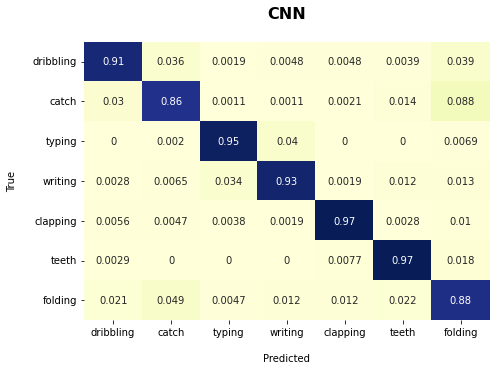

In [ ]:
save = False

cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1), normalize='true')
if dataset_name == "wisdm2":
    labels = ConfusionMatrix_wisdm2_labels()
else:
    labels = ConfusionMatrix_labels(y_train, y_test)
cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
plt.figure(figsize=(7,5.25))
sn.heatmap(cm_df,
           annot=True,
           fmt='.2g',
           cbar=False,
           square=False,
           cmap="YlGnBu")
plt.xlabel('\nPredicted')
plt.ylabel('True\n')
plt.yticks(rotation=0)
plt.title('CNN\n', fontweight='bold', fontsize=16)
plt.tight_layout()
if save:
    plt.savefig('./pictures/'+model_name+'_'+optim_nni_experiment+'_'+optim_nni_trial+'.png')
plt.show()

<a id='Section_3'></a>
### Spiking CNN

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
net_type = 'scnn'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
datafile = 'watch_subset2_40'

###########################################################################################

In [ ]:
model_name = "sCNN_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS from NNI-optimized non-spiking CNN #####
optim_nni_experiment = ''

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format("cnn",optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+optim_nni_experiment+'/trials/'+optim_nni_trial
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['nni_network/batch_size/randint']
##############################################################################


##### GET SNN PARAMETERS #####
snn_nni_experiment = ''

snn_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(snn_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,snn_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if snn_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(snn_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

snn_nni_trial = df_default["trialJobId"].iloc[0] 
snn_filename = 'parameter.cfg'
snn_nni_ref = 'nni-experiments/'+snn_nni_experiment+'/trials/'+snn_nni_trial
snn_nni_dir = os.path.expanduser('~')
snn_filepath = os.path.join(snn_nni_dir,snn_nni_ref,snn_filename)

local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,snn_nni_experiment)

for ii in os.listdir(local_experiment_folder):
  if snn_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(snn_filepath[1:]), 'r') as f:
    snn_data = f.read()

snn_params = json.loads(snn_data)
snn_parameters = snn_params['parameters']
##############################

Best optimization trial: WB3TV with default metric value 87.83157894736841


In [ ]:
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset(datafile)

timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])

y_train = np.argmax(y_train_oh, axis=-1)
y_val = np.argmax(y_val_oh, axis=-1)
y_test = np.argmax(y_test_oh, axis=-1)

print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

### flatten data and add time dimension:
x_train = x_train.reshape((x_train.shape[0], 1, -1))
y_train = y_train[:,None,None]
x_val = x_val.reshape((x_val.shape[0], 1, -1))
y_val = y_val[:,None,None]
x_test = x_test.reshape((x_test.shape[0], 1, -1))
y_test = y_test[:,None,None]

timesteps: 40
input_dim: 6
n_classes: 7


In [ ]:
model_nonspiking = Sequential()    
model_nonspiking.add(Conv1D(filters=network_parameters['nni_network/Conv1D_filters_1/randint'], kernel_size=network_parameters['nni_network/Conv1D_kernel_size_1/randint'], activation=tf.nn.relu, kernel_initializer='he_uniform', input_shape=(timesteps,input_dim), name='Conv1D_1'))
model_nonspiking.add(Conv1D(filters=network_parameters['nni_network/Conv1D_filters_2/randint'], kernel_size=network_parameters['nni_network/Conv1D_kernel_size_2/randint'], activation=tf.nn.relu, kernel_initializer='he_uniform', name='Conv1D_2'))
model_nonspiking.add(MaxPooling1D(pool_size=2, name='MaxPooling1D'))
model_nonspiking.add(Flatten())
model_nonspiking.add(Dense(network_parameters['nni_network/CNN_Dense_1/randint'], activation=tf.nn.relu, name='Dense_1'))
model_nonspiking.add(Dense(n_classes, activation='softmax', name='Dense_2'))
    
### LOAD PRE-TRAINED WEIGHTS from NNI-optimized non-spiking CNN ###
local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format("cnn",optim_nni_experiment)

for ii in os.listdir(local_output_folder):
  if "output" in ii:
    target = ii

zf = zipfile.ZipFile(local_output_folder+target)
zf.extractall()

model_nonspiking.load_weights("./output/tmp_{}_{}_{}/best_test/best_test_{}".format("cnn",optim_nni_experiment,dataset_name,optim_nni_experiment))

### sequential to functional model
input_layer = Input(batch_shape=model_nonspiking.layers[0].input_shape, name='Input')
prev_layer = input_layer
for num,el in enumerate(model_nonspiking.layers):
    prev_layer = el(prev_layer)

model = Model([input_layer], [prev_layer])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 40, 6)]           0         
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 38, 76)            1444      
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 36, 56)            12824     
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 18, 56)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 76)                76684     
_________________________________________________________________
Dense_2 (Dense)              (None, 7)                 539   

In [ ]:
keras_layers = list(model.layers[ii].name for ii in range(len(model.layers)))

In [ ]:
trained_converter = nengo_dl.Converter(model,
                                       max_to_avg_pool=True,
                                       swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
                                       scale_firing_rates=snn_parameters['nni_keras2snn_network/scale_firing_rates/randint'],
                                       synapse=snn_parameters['nni_keras2snn_network/synapse/quniform'],
                                       )

print('\n##### neuron type now is:')
for ii in range(len(trained_converter.net.ensembles)):
    print('In ensemble',ii,':',trained_converter.net.ensembles[ii].neuron_type)
print('#########################\n')


##### neuron type now is:
In ensemble 0 : SpikingRectifiedLinear(amplitude=0.012987012987012988)
In ensemble 1 : SpikingRectifiedLinear(amplitude=0.012987012987012988)
In ensemble 2 : SpikingRectifiedLinear(amplitude=0.012987012987012988)
#########################



/usr/local/lib/python3.7/dist-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x7fcaef974050> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [ ]:
with trained_converter.net:
    output_p = trained_converter.outputs[model.output]
    conv0_p = nengo.Probe(trained_converter.layers[model.layers[1].get_output_at(-1)])
    conv1_p = nengo.Probe(trained_converter.layers[model.layers[2].get_output_at(-1)])

In [ ]:
n_steps = snn_parameters['nni_keras2snn_network/n_steps/randint']

tiled_x_test = np.tile(x_test, (1, n_steps, 1))

Build finished in 0:00:00                                                      
|#             Optimizing graph: operator simplificaton               | 0:00:00

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               

Total params: 102,667
Trainable params: 91,491
Non-trainable params: 11,176
_________________________________________________________________

Memory footprint (MB): 0.4107
Total: 102667
Missed: 0




/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:1773: UserWarning: Number of elements (1) in ['str'] does not match number of Probes (3); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  len(objects),
/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:1930: UserWarning: Number of elements in input data (7241) is not evenly divisible by Simulator.minibatch_size (125); input data will be truncated.
  % (data_batch, self.minibatch_size)


Test accuracy: 87.73%


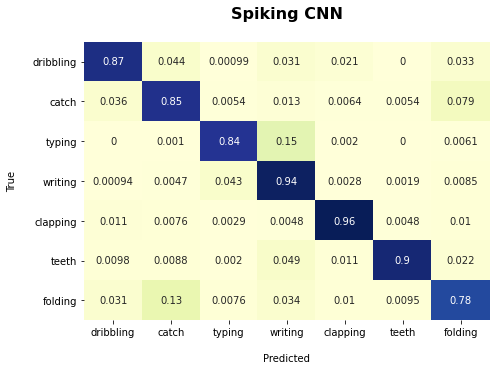

In [ ]:
with nengo_dl.Simulator(trained_converter.net, minibatch_size=snn_parameters['nni_keras2snn_network/batch_size/randint']) as sim:
    snn_model_summary = sim.keras_model
    snn_params = sum(np.prod(s.shape) for s in snn_model_summary.weights)
    snn_trainable_params = sum(np.prod(w.shape) for w in snn_model_summary.trainable_weights)
    print('\n=================================================================')
    print('Total params:','{:,d}'.format(snn_params))
    print('Trainable params:','{:,d}'.format(snn_trainable_params))
    print('Non-trainable params:','{:,d}'.format(snn_params-snn_trainable_params))
    print('_________________________________________________________________\n')
    
    mem_fp, total, missed = memory_footprint(sim)

    print('Memory footprint (MB):',np.round(mem_fp,4))
    print('Total:',total)
    print('Missed:',missed)
    print("\n")
    
    sim.compile(
                optimizer=tf.optimizers.Adam(snn_parameters['nni_keras2snn_network/lr/quniform']),
                loss={
                      output_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                      conv0_p: tf.losses.mse,
                      conv1_p: tf.losses.mse,
                     },
                loss_weights={
                              output_p: 1, 
                              conv0_p: snn_parameters['nni_keras2snn_network/reg_conv0/quniform'], 
                              conv1_p: snn_parameters['nni_keras2snn_network/reg_conv1/quniform']
                             },
                metrics=["accuracy"],
               )
    
    local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,snn_nni_experiment)

    for ii in os.listdir(local_output_folder):
      if "output" in ii:
        target = ii

    zf = zipfile.ZipFile(local_output_folder+target)
    zf.extractall()

    sim.load_params("./output/tmp_{}_{}_{}/best_test_{}".format(net_type,snn_nni_experiment,datafile[5:],snn_nni_experiment))
        
    data = sim.predict({trained_converter.inputs[model.input]: tiled_x_test})
    predictions = np.argmax(data[trained_converter.outputs[model.output]][:, -1], axis=-1)
    test_accuracy = (predictions[:] == y_test[:predictions.shape[0], 0, 0]).mean()
    print("Test accuracy: "+str(np.round(test_accuracy*100,2))+"%")
    
    save = False

    cm = confusion_matrix(y_test[:np.min([len(y_test), len(predictions)]),-1,-1], predictions[:np.min([len(y_test), len(predictions)])], normalize='true')
    if dataset_name == "wisdm2":
        labels = ConfusionMatrix_wisdm2_labels()
    else:
        labels = ConfusionMatrix_labels(y_train, y_test)
    cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
    plt.figure(figsize=(7,5.25))
    sn.heatmap(cm_df,
               annot=True,
               fmt='.2g',
               cbar=False,
               square=False,
               cmap="YlGnBu")
    plt.xlabel('\nPredicted')
    plt.ylabel('True\n')
    plt.yticks(rotation=0)
    plt.title('Spiking CNN\n', fontweight='bold', fontsize=16)
    plt.tight_layout()
    if save:
        plt.savefig('./pictures/'+model_name+'_'+snn_nni_experiment+'_'+snn_nni_trial+'.png')
    plt.show()

sim.close()

In [ ]:
get_sops_spikingCNN(trained_converter.net)

Build finished in 0:00:00                                                      
|#             Optimizing graph: operator simplificaton               | 0:00:00

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Simulation finished in 0:00:02                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00          

<a id='Section_4'></a>
### LMU

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
net_type = 'lmu'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
datafile = 'watch_subset2_40'

###########################################################################################

In [ ]:
model_name = "LMU_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS #####
optim_nni_experiment = ''

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+optim_nni_experiment+'/trials/'+optim_nni_trial
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['minibatch']
###########################################

In [ ]:
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset(datafile)
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])

y_train = np.argmax(y_train_oh, axis=-1)
y_val = np.argmax(y_val_oh, axis=-1)
y_test = np.argmax(y_test_oh, axis=-1)

print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

y_train = y_train[:, None, None]
y_test = y_test[:, None, None]
y_val = y_val[:, None, None]

In [ ]:
with nengo.Network(seed=seed) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
                                trainable=None,
                                stateful=False,
                                keep_history=False,
                               )

    # input node
    inp = nengo.Node(np.zeros(input_dim))

    # lmu cell
    lmu = LMUCell(
                  units=int(network_parameters['units']), 
                  order=int(network_parameters['order']), 
                  theta=network_parameters['theta'],
                  input_d=input_dim,
                  tau=network_parameters['tau'],
                )
    conn_in = nengo.Connection(inp, lmu.x, synapse=network_parameters['synapse_in'])
    net.config[conn_in].trainable = True

    # dense linear readout
    out = nengo.Node(size_in=n_classes)
    conn_out = nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=network_parameters['synapse_out'])
    net.config[conn_out].trainable = True

    # record output
    p = nengo.Probe(out)

In [ ]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_train) as sim:
    
    lmu_model_summary = sim.keras_model
    lmu_params = sum(np.prod(s.shape) for s in lmu_model_summary.weights)
    lmu_trainable_params = sum(np.prod(w.shape) for w in lmu_model_summary.trainable_weights)
    mem_fp, total, missed = memory_footprint(sim) 
    print('\n=================================================================')
    print('Total params:','{:,d}'.format(lmu_params))
    print('Trainable params:','{:,d}'.format(lmu_trainable_params))
    print('Non-trainable params:','{:,d}'.format(lmu_params-lmu_trainable_params))
    print('_________________________________________________________________\n')
    
    mem_fp, total, missed = memory_footprint(sim)

    print('Memory footprint (MB):',np.round(mem_fp,4))
    print('Total:',total)
    print('Missed:',missed)
    print("\n")
    
    sim.compile(
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam(network_parameters['lr']),
                metrics=["accuracy"],
               )
    
    ### LOAD THE PRE-TRAINED WEIGHTS ###
    local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)

    for ii in os.listdir(local_output_folder):
      if "output" in ii:
        target = ii

    zf = zipfile.ZipFile(local_output_folder+target)
    zf.extractall()

    sim.load_params("./output/tmp_{}_{}_{}/best_test_{}".format(net_type,optim_nni_experiment,dataset_name,optim_nni_experiment))
    ###
    
    test = sim.evaluate(x_test, y_test)["probe_accuracy"]
    print("Test accuracy: "+str(np.round(test*100,2))+"%")
    
    prediction = sim.predict(x_test)
        
    predictions = list(prediction.values())[0]
    pred = predictions.argmax(axis=-1)
    
    save = False
    
    cm = confusion_matrix(y_test[:np.min([len(y_test), len(pred)]),-1,-1], pred[:np.min([len(y_test), len(pred)]),-1], normalize='true')
    if dataset_name == "wisdm2":
        labels = ConfusionMatrix_wisdm2_labels()
    else:
        labels = ConfusionMatrix_labels(y_train, y_test)
    cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
    plt.figure(figsize=(7,5.25))
    sn.heatmap(cm_df,
               annot=True,
               fmt='.2g',
               cbar=False,
               square=False,
               cmap="YlGnBu")
    plt.xlabel('\nPredicted')
    plt.ylabel('True\n')
    plt.title('LMU\n', fontweight='bold', fontsize=16)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save:
        plt.savefig('./pictures/'+model_name+'_'+optim_nni_experiment+'_'+optim_nni_trial+'.png')
    plt.show()

sim.close()

<a id='Section_5'></a>
### Spiking LMU

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
net_type = 'slmu'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
#datafile = 'watch_subset2_40'
datafile = 'data_watch_40'

###########################################################################################

In [ ]:
! pwd
import pickle

nni_slmu_dict = pickle.load(open('./experiments/nni_slmu_dict.pkl', 'rb'))
separate_datasets = pickle.load(open('./experiments/separate_datasets.pkl', 'rb'))

/content/drive/.shortcut-targets-by-id/1T6FJpkctCqYwsEyKqCHvg29DYOd3H-KH/Project/NNI


In [ ]:
model_name = "sLMU_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS #####
cluster_index = 5
experiments = ['c0_KCzsw1MN', 'c1_xZ9qiVvQ', 'c2_1RFtuizL', 'c3_EnCi34wL', 'hE7GnMeb']

#optim_nni_experiment = 'c0_KCzsw1MN' #c0
#optim_nni_experiment = 'c1_xZ9qiVvQ' #c1
#optim_nni_experiment = 'c2_1RFtuizL' #c2
#optim_nni_experiment = 'c3v1_K3I4pf9U' #c3
#optim_nni_experiment = 'c3v2_EnCi34wL' #c3
#optim_nni_experiment = 'gGm02lpZ' #boh?
optim_nni_experiment = experiments[cluster_index]
if cluster_index==5:
  correct_optim_nni_experiment = optim_nni_experiment
else:
  correct_optim_nni_experiment = optim_nni_experiment.split("_")[-1]
if cluster_index==4:
  cluster_index=3
elif cluster_index==5:
  cluster_index=-1

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(correct_optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/Project/evaluations/Experiment_{}_{}".format(net_type,optim_nni_experiment)
#local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  print(optim_nni_experiment)
  if correct_optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+"/"+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+correct_optim_nni_experiment+'/trials/'+optim_nni_trial
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+"/"+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['minibatch']
###########################################

hE7GnMeb
hE7GnMeb
Best optimization trial: lVgNj with default metric value 68.09616684913635


In [ ]:
(x_train, x_val, x_test, y_train, y_val, y_test) = load_dataset(datafile)
#(x_train, x_test, y_train, y_test) = nni_slmu_dict[cluster_index]['train']['data'], nni_slmu_dict[cluster_index]['test']['data'],  nni_slmu_dict[cluster_index]['train']['labels'], nni_slmu_dict[cluster_index]['test']['labels']
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])
#n_classes = len(separate_datasets[cluster_index]['classes'])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

x_val = x_train[int(y_train.shape[0]*0.8):]
x_train = x_train[0:int(y_train.shape[0]*0.8)]
y_val = y_train[int(y_train.shape[0]*0.8):]
y_train = y_train[0:int(y_train.shape[0]*0.8)]

#commentare se cluster:
#'''
y_train = np.argmax(y_train, axis=-1)
y_val = np.argmax(y_val, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_train = y_train[:, None, None]
y_test = y_test[:, None, None]
y_val = y_val[:, None, None]
#'''

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(110807, 40, 6)
(36936, 40, 6)
(110807, 18)
(36936, 18)
timesteps: 40
input_dim: 6
n_classes: 18
(88645, 40, 6)
(22162, 40, 6)
(36936, 40, 6)
(88645, 1, 1)
(22162, 1, 1)
(36936, 1, 1)


In [ ]:
with nengo.Network(seed=seed) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        keep_history=False,
    )

    # input node
    inp = nengo.Node(np.zeros(input_dim))
    
    order = int(network_parameters['order'])
    theta = network_parameters['theta']
    input_d = input_dim
    tau = network_parameters['tau'] 
    
    Q = np.arange(order, dtype=np.float64)
    R = (2 * Q + 1)[:, None] / theta
    j, i = np.meshgrid(Q, Q)
    A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R 
    B = (-1.0) ** Q[:, None] * R 
    C = np.ones((1, order))
    D = np.zeros((1,))

    disc_step = 1/theta
    A, B, _, _, _ = cont2discrete((A, B, C, D), dt=disc_step, method="zoh")
    
    A_H = 1/(1-np.exp(-disc_step/tau)) * (A - np.exp(-disc_step/tau)*np.identity(order))
    B_H = 1/(1-np.exp(-disc_step/tau)) * B

    for conn in net.all_connections:
        conn.synapse = network_parameters['synapse_all']

    max_rate = network_parameters['max_rate']
    amplitude = 1/max_rate
    lmu_inner = nengo.networks.EnsembleArray(n_neurons=int(network_parameters['n_neurons']),
                                             n_ensembles=order, 
                                             neuron_type=nengo.SpikingRectifiedLinear(amplitude=amplitude),
                                             max_rates=nengo.dists.Choice([max_rate]))
    conn_inner = nengo.Connection(lmu_inner.output, lmu_inner.input, transform=A_H, synapse=tau)
    net.config[conn_inner].trainable = True
    
    conn_in = nengo.Connection(inp, lmu_inner.input, transform=np.ones((1, input_d))*B_H, synapse=network_parameters['synapse_in'])
    net.config[conn_in].trainable = True
    
    # dense linear readout
    out = nengo.Node(size_in=n_classes)
    conn_out = nengo.Connection(lmu_inner.output, out, transform=nengo_dl.dists.Glorot(), synapse=network_parameters['synapse_out'])
    net.config[conn_out].trainable = True

    # record output
    p = nengo.Probe(out)

In [ ]:
def labels_identification_wisdm2(cluster_ind=-1):
    act_map = {'A': 'walking', 'B': 'jogging', 'C': 'stairs', 'D': 'sitting', 'E': 'standing', 'M': 'kicking', 'P': 'dribbling', 'O': 'catch', 'F': 'typing',
        'Q': 'writing', 'R': 'clapping', 'G': 'teeth', 'S': 'folding', 'J': 'pasta', 'H': 'soup', 'L': 'sandwich', 'I': 'chips', 'K': 'drinking', }
    labels = list(act_map.values())[0:18]
    if cluster_ind!=-1:
      temp_labels = []
      for i in separate_datasets[cluster_index]['classes']:
        temp_labels.append(labels[i])
      labels = temp_labels
    return labels

In [ ]:
print(separate_datasets[cluster_index].keys())
print(separate_datasets[cluster_index]['classes'])

KeyError: ignored

|########             Building network (12%)                     | ETA: 0:00:01

/usr/local/lib/python3.7/dist-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               

Total params: 77,292
Trainable params: 77,292
Non-trainable params: 0
_________________________________________________________________

Memory footprint (MB): 0.3092
Total: 77292
Missed: 0


324/324 [==============================] - 285s 878ms/step - loss: 0.9952 - probe_loss: 0.9952 - probe_accuracy: 0.6784
Test accuracy: 68.09%

labels
['walking', 'jogging', 'stairs', 'sitting', 'standing', 'kicking', 'dribbling', 'catch', 'typing', 'writing', 'clapping', 'teeth', 'folding', 'pasta', 'soup', 'sandwich', 'chips', 'drinking']


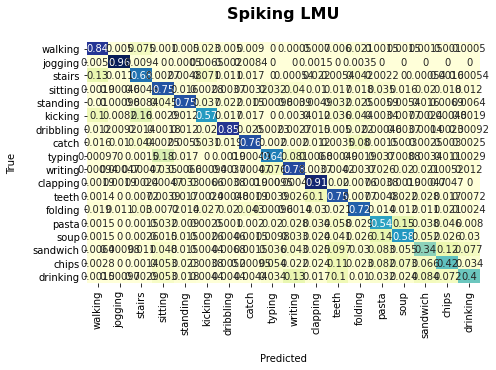

In [ ]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_train) as sim: 
    
    lmuEns_model_summary = sim.keras_model
    lmuEns_params = sum(np.prod(s.shape) for s in lmuEns_model_summary.weights)
    lmuEns_trainable_params = sum(np.prod(w.shape) for w in lmuEns_model_summary.trainable_weights)
    mem_fp, total, missed = memory_footprint(sim) 
    print('\n=================================================================')
    print('Total params:','{:,d}'.format(lmuEns_params))
    print('Trainable params:','{:,d}'.format(lmuEns_trainable_params))
    print('Non-trainable params:','{:,d}'.format(lmuEns_params-lmuEns_trainable_params))
    print('_________________________________________________________________\n')
    
    mem_fp, total, missed = memory_footprint(sim)

    print('Memory footprint (MB):',np.round(mem_fp,4))
    print('Total:',total)
    print('Missed:',missed)
    print("\n")
    
    sim.compile(
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam(network_parameters['lr']),
                metrics=["accuracy"],
               )
    
    ### LOAD THE PRE-TRAINED WEIGHTS ###
    local_output_folder = "/content/drive/MyDrive/Project/evaluations/Experiment_{}_{}".format(net_type,optim_nni_experiment)
    #local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)

    for ii in os.listdir(local_output_folder):
      if "output" in ii:
        target = ii

    zf = zipfile.ZipFile(local_output_folder+"/"+target)
    zf.extractall()

    sim.load_params("./output/tmp_{}_{}_{}/best_test_{}".format(net_type,correct_optim_nni_experiment,dataset_name,correct_optim_nni_experiment))
    ###
    
    test = sim.evaluate(x_test, y_test)["probe_accuracy"]
    print("Test accuracy: "+str(np.round(test*100,2))+"%")
    
    prediction = sim.predict(x_test)
        
    predictions = list(prediction.values())[0]
    pred = predictions.argmax(axis=-1)
    
    save = False
    
    print()
    y_true = y_test[:np.min([len(y_test), len(pred)]),-1,-1]
    y_test = pred[:np.min([len(y_test), len(pred)]),-1]
    cm = confusion_matrix(y_true, y_test, normalize='true')

    if dataset_name == "wisdm2":
        labels = labels_identification_wisdm2(cluster_index)
    else:
        labels = ConfusionMatrix_labels(y_train, y_test)

    print("labels")
    print(labels)
    
    cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
    plt.figure(figsize=(7,5.25))
    sn.heatmap(cm_df,
               annot=True,
               fmt='.2g',
               cbar=False,
               square=False,
               cmap="YlGnBu")
    plt.xlabel('\nPredicted')
    plt.ylabel('True\n')
    plt.title('Spiking LMU\n', fontweight='bold', fontsize=16)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save:
        plt.savefig('./pictures/'+model_name+'_'+optim_nni_experiment+'_'+optim_nni_trial+'.png')
    plt.show()

sim.close()

In [ ]:
get_sops_LMUens(net)

|######                Building network (9%)                     | ETA: 0:00:01

/usr/local/lib/python3.7/dist-packages/nengo/networks/ensemblearray.py:188: UserWarning: neuron_output already exists. Returning.
  warnings.warn("neuron_output already exists. Returning.")


Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
LEN
3693.6000000000004
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finish

<a id='Section_6'></a>
### LMU (ff)

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
net_type = 'lmu'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
datafile = 'watch_subset2_40'

###########################################################################################

In [ ]:
model_name = "LMU_freqdec_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS #####
optim_nni_experiment = ''

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+optim_nni_experiment+'/trials/'+optim_nni_trial
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['minibatch']
###########################################

In [ ]:
freq_dec = True

In [ ]:
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset(datafile)

if freq_dec:
    x_train = frequency_decomposition(x_train)
    x_val = frequency_decomposition(x_val)
    x_test = frequency_decomposition(x_test)

timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])

y_train = np.argmax(y_train_oh, axis=-1)
y_val = np.argmax(y_val_oh, axis=-1)
y_test = np.argmax(y_test_oh, axis=-1)

print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

y_train = y_train[:, None, None]
y_test = y_test[:, None, None]
y_val = y_val[:, None, None]

In [ ]:
with nengo.Network(seed=seed) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
                                trainable=None,
                                stateful=False,
                                keep_history=False,
                               )

    # input node
    inp = nengo.Node(np.zeros(input_dim))

    # lmu cell
    lmu = LMUCell(
                  units=int(network_parameters['units']),
                  order=int(network_parameters['order']), 
                  theta=network_parameters['theta'], 
                  input_d=input_dim,
                  tau=network_parameters['tau'],
                )
    conn_in = nengo.Connection(inp, lmu.x, synapse=network_parameters['synapse_in'])
    net.config[conn_in].trainable = True

    # dense linear readout
    out = nengo.Node(size_in=n_classes)
    conn_out = nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=network_parameters['synapse_out'])
    net.config[conn_out].trainable = True

    # record output
    p = nengo.Probe(out)

In [ ]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_train) as sim:
    
    lmu_model_summary = sim.keras_model
    lmu_params = sum(np.prod(s.shape) for s in lmu_model_summary.weights)
    lmu_trainable_params = sum(np.prod(w.shape) for w in lmu_model_summary.trainable_weights)
    mem_fp, total, missed = memory_footprint(sim) 
    print('\n=================================================================')
    print('Total params:','{:,d}'.format(lmu_params))
    print('Trainable params:','{:,d}'.format(lmu_trainable_params))
    print('Non-trainable params:','{:,d}'.format(lmu_params-lmu_trainable_params)) 
    print('_________________________________________________________________\n')
    
    mem_fp, total, missed = memory_footprint(sim)

    print('Memory footprint (MB):',np.round(mem_fp,4))
    print('Total:',total)
    print('Missed:',missed)
    print("\n")
    
    sim.compile(
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam(network_parameters['lr']),
                metrics=["accuracy"],
               )
    
    ### LOAD THE PRE-TRAINED WEIGHTS ###
    local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)

    for ii in os.listdir(local_output_folder):
      if "output" in ii:
        target = ii

    zf = zipfile.ZipFile(local_output_folder+target)
    zf.extractall()

    sim.load_params("./output/tmp_{}_{}_{}/best_test_{}".format(net_type,optim_nni_experiment,dataset_name,optim_nni_experiment))
    ###
    
    test = sim.evaluate(x_test, y_test)["probe_accuracy"]
    print("Test accuracy: "+str(np.round(test*100,2))+"%")
    
    prediction = sim.predict(x_test)
        
    predictions = list(prediction.values())[0]
    pred = predictions.argmax(axis=-1)
    
    save = True
    
    cm = confusion_matrix(y_test[:np.min([len(y_test), len(pred)]),-1,-1], pred[:np.min([len(y_test), len(pred)]),-1], normalize='true')
    if dataset_name == "wisdm2":
        labels = ConfusionMatrix_wisdm2_labels()
    else:
        labels = ConfusionMatrix_labels(y_train, y_test)
    cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
    plt.figure(figsize=(7,5.25))
    sn.heatmap(cm_df,
               annot=True,
               fmt='.2g',
               cbar=False,
               square=False,
               cmap="YlGnBu")
    plt.xlabel('\nPredicted')
    plt.ylabel('True\n')
    plt.title('LMU (frequency filtering)\n', fontweight='bold', fontsize=16)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save:
        plt.savefig('./pictures/'+model_name+'_'+optim_nni_experiment+'_'+optim_nni_trial+'.png')
    plt.show()

sim.close()

<a id='Section_7'></a>
### Spiking LMU (ff)

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
net_type = 'slmu'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
datafile = 'watch_subset2_40'

###########################################################################################

In [ ]:
model_name = "sLMU_freqdec_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS #####
optim_nni_experiment = ''

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+optim_nni_experiment+'/trials/'+optim_nni_trial
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['minibatch']
###########################################

In [ ]:
freq_dec = True

In [ ]:
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset(datafile)

if freq_dec:
    x_train = frequency_decomposition(x_train)
    x_val = frequency_decomposition(x_val)
    x_test = frequency_decomposition(x_test)

timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])

y_train = np.argmax(y_train_oh, axis=-1)
y_val = np.argmax(y_val_oh, axis=-1)
y_test = np.argmax(y_test_oh, axis=-1)

print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

y_train = y_train[:, None, None]
y_test = y_test[:, None, None]
y_val = y_val[:, None, None]

In [ ]:
with nengo.Network(seed=seed) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        keep_history=False,
    )

    # input node
    inp = nengo.Node(np.zeros(input_dim))
    
    order = int(network_parameters['order'])
    theta = network_parameters['theta']
    input_d = input_dim
    tau = network_parameters['tau'] 
    
    Q = np.arange(order, dtype=np.float64)
    R = (2 * Q + 1)[:, None] / theta
    j, i = np.meshgrid(Q, Q)
    A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R 
    B = (-1.0) ** Q[:, None] * R 
    C = np.ones((1, order))
    D = np.zeros((1,))

    disc_step = 1/theta
    A, B, _, _, _ = cont2discrete((A, B, C, D), dt=disc_step, method="zoh") 
    
    A_H = 1/(1-np.exp(-disc_step/tau)) * (A - np.exp(-disc_step/tau)*np.identity(order))
    B_H = 1/(1-np.exp(-disc_step/tau)) * B

    for conn in net.all_connections:
        conn.synapse = network_parameters['synapse_all']

    max_rate = network_parameters['max_rate']
    amplitude = 1/max_rate
    lmu_inner = nengo.networks.EnsembleArray(n_neurons=int(network_parameters['n_neurons']),
                                             n_ensembles=order, 
                                             neuron_type=nengo.SpikingRectifiedLinear(amplitude=amplitude),
                                             max_rates=nengo.dists.Choice([max_rate]))
    conn_inner = nengo.Connection(lmu_inner.output, lmu_inner.input, transform=A_H, synapse=tau)
    net.config[conn_inner].trainable = True
    
    conn_in = nengo.Connection(inp, lmu_inner.input, transform=np.ones((1, input_d))*B_H, synapse=network_parameters['synapse_in'])
    net.config[conn_in].trainable = True
    
    # dense linear readout
    out = nengo.Node(size_in=n_classes)
    conn_out = nengo.Connection(lmu_inner.output, out, transform=nengo_dl.dists.Glorot(), synapse=network_parameters['synapse_out'])
    net.config[conn_out].trainable = True

    # record output
    p = nengo.Probe(out)

In [ ]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_train) as sim: 
    
    lmuEns_model_summary = sim.keras_model
    lmuEns_params = sum(np.prod(s.shape) for s in lmuEns_model_summary.weights)
    lmuEns_trainable_params = sum(np.prod(w.shape) for w in lmuEns_model_summary.trainable_weights)
    mem_fp, total, missed = memory_footprint(sim) 
    print('\n=================================================================')
    print('Total params:','{:,d}'.format(lmuEns_params))
    print('Trainable params:','{:,d}'.format(lmuEns_trainable_params))
    print('Non-trainable params:','{:,d}'.format(lmuEns_params-lmuEns_trainable_params)) 
    print('_________________________________________________________________\n')
    
    mem_fp, total, missed = memory_footprint(sim)

    print('Memory footprint (MB):',np.round(mem_fp,4))
    print('Total:',total)
    print('Missed:',missed)
    print("\n")
    
    sim.compile(
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam(network_parameters['lr']),
                metrics=["accuracy"],
               )
    
    ### LOAD THE PRE-TRAINED WEIGHTS ###
    local_output_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)

    for ii in os.listdir(local_output_folder):
      if "output" in ii:
        target = ii

    zf = zipfile.ZipFile(local_output_folder+target)
    zf.extractall()

    sim.load_params("./output/tmp_{}_{}_{}/best_test_{}".format(net_type,optim_nni_experiment,dataset_name,optim_nni_experiment))
    ###
    
    test = sim.evaluate(x_test, y_test)["probe_accuracy"]
    print("Test accuracy: "+str(np.round(test*100,2))+"%")
    
    prediction = sim.predict(x_test)
        
    predictions = list(prediction.values())[0]
    pred = predictions.argmax(axis=-1)
    
    save = True
    
    cm = confusion_matrix(y_test[:np.min([len(y_test), len(pred)]),-1,-1], pred[:np.min([len(y_test), len(pred)]),-1], normalize='true')
    if dataset_name == "wisdm2":
        labels = ConfusionMatrix_wisdm2_labels()
    else:
        labels = ConfusionMatrix_labels(y_train, y_test)
    cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
    plt.figure(figsize=(7,5.25))
    sn.heatmap(cm_df,
               annot=True,
               fmt='.2g',
               cbar=False,
               square=False,
               cmap="YlGnBu")
    plt.xlabel('\nPredicted')
    plt.ylabel('True\n')
    plt.title('Spiking LMU (frequency filtering)\n', fontweight='bold', fontsize=16)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save:
        plt.savefig('./pictures/'+model_name+'_'+optim_nni_experiment+'_'+optim_nni_trial+'.png')
    plt.show()

sim.close()

In [ ]:
get_sops_LMUens(net, freq_dec)

<a id='Section_8'></a>
### <i>FLOPs calculation and energy estimation for LMU and LMU (ff)</i>

In [ ]:
"""
Core classes for the KerasLMU package.
"""

import numpy as np
import tensorflow as tf
from packaging import version

if version.parse(tf.__version__) < version.parse("2.6.0rc0"):
    from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
else:
    from keras.layers.recurrent import DropoutRNNCellMixin


class LMUCell(DropoutRNNCellMixin, tf.keras.layers.Layer):
    """
    Implementation of LMU cell (to be used within Keras RNN wrapper).
    In general, the LMU cell consists of two parts: a memory component (decomposing
    the input signal using Legendre polynomials as a basis), and a hidden component
    (learning nonlinear mappings from the memory component). [1]_ [2]_
    This class processes one step within the whole time sequence input. Use the ``LMU``
    class to create a recurrent Keras layer to process the whole sequence. Calling
    ``LMU()`` is equivalent to doing ``RNN(LMUCell())``.
    Parameters
    ----------
    memory_d : int
        Dimensionality of input to memory component.
    order : int
        The number of degrees in the transfer function of the LTI system used to
        represent the sliding window of history. This parameter sets the number of
        Legendre polynomials used to orthogonally represent the sliding window.
    theta : float
        The number of timesteps in the sliding window that is represented using the
        LTI system. In this context, the sliding window represents a dynamic range of
        data, of fixed size, that will be used to predict the value at the next time
        step. If this value is smaller than the size of the input sequence, only that
        number of steps will be represented at the time of prediction, however the
        entire sequence will still be processed in order for information to be
        projected to and from the hidden layer. If ``trainable_theta`` is enabled, then
        theta will be updated during the course of training.
    hidden_cell : ``tf.keras.layers.Layer``
        Keras Layer/RNNCell implementing the hidden component.
    trainable_theta : bool
        If True, theta is learnt over the course of training. Otherwise, it is kept
        constant.
    hidden_to_memory : bool
        If True, connect the output of the hidden component back to the memory
        component (default False).
    memory_to_memory : bool
        If True, add a learnable recurrent connection (in addition to the static
        Legendre system) to the memory component (default False).
    input_to_hidden : bool
        If True, connect the input directly to the hidden component (in addition to
        the connection from the memory component) (default False).
    discretizer : str
        The method used to discretize the A and B matrices of the LMU. Current
        options are "zoh" (short for Zero Order Hold) and "euler".
        "zoh" is more accurate, but training will be slower than "euler" if
        ``trainable_theta=True``. Note that a larger theta is needed when discretizing
        using "euler" (a value that is larger than ``4*order`` is recommended).
    kernel_initializer : ``tf.initializers.Initializer``
        Initializer for weights from input to memory/hidden component. If ``None``,
        no weights will be used, and the input size must match the memory/hidden size.
    recurrent_initializer : ``tf.initializers.Initializer``
        Initializer for ``memory_to_memory`` weights (if that connection is enabled).
    dropout : float
        Dropout rate on input connections.
    recurrent_dropout : float
        Dropout rate on ``memory_to_memory`` connection.
    References
    ----------
    .. [1] Voelker and Eliasmith (2018). Improving spiking dynamical
       networks: Accurate delays, higher-order synapses, and time cells.
       Neural Computation, 30(3): 569-609.
    .. [2] Voelker and Eliasmith. "Methods and systems for implementing
       dynamic neural networks." U.S. Patent Application No. 15/243,223.
       Filing date: 2016-08-22.
    """

    def __init__(
        self,
        memory_d,
        order,
        theta,
        hidden_cell,
        trainable_theta=False,
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=False,
        discretizer="zoh",
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        dropout=0,
        recurrent_dropout=0,
        tau=0.001, 
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.memory_d = memory_d
        self.order = order
        self._init_theta = theta
        self.hidden_cell = hidden_cell
        self.trainable_theta = trainable_theta
        self.hidden_to_memory = hidden_to_memory
        self.memory_to_memory = memory_to_memory
        self.input_to_hidden = input_to_hidden
        self.discretizer = discretizer
        self.kernel_initializer = kernel_initializer
        self.recurrent_initializer = recurrent_initializer
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.tau = tau

        self.kernel = None
        self.recurrent_kernel = None
        self.theta_inv = None
        self.A = None
        self.B = None

        if self.discretizer not in ("zoh", "euler"):
            raise ValueError(
                f"discretizer must be 'zoh' or 'euler' (got '{self.discretizer}')"
            )

        if self.hidden_cell is None:
            for conn in ("hidden_to_memory", "input_to_hidden"):
                if getattr(self, conn):
                    raise ValueError(f"{conn} must be False if hidden_cell is None")

            self.hidden_output_size = self.memory_d * self.order
            self.hidden_state_size = []
        elif hasattr(self.hidden_cell, "state_size"):
            self.hidden_output_size = self.hidden_cell.output_size
            self.hidden_state_size = self.hidden_cell.state_size
        else:
            # TODO: support layers that don't have the `units` attribute
            self.hidden_output_size = self.hidden_cell.units
            self.hidden_state_size = [self.hidden_cell.units]

        self.state_size = tf.nest.flatten(self.hidden_state_size) + [
            self.memory_d * self.order
        ]
        self.output_size = self.hidden_output_size

    @property
    def theta(self):
        """
        Value of the ``theta`` parameter.
        If ``trainable_theta=True`` this returns the trained value, not the initial
        value passed in to the constructor.
        """
        if self.built:
            return 1 / tf.keras.backend.get_value(self.theta_inv)

        return self._init_theta

    def _gen_AB(self):
        """Generates A and B matrices."""

        # compute analog A/B matrices
        Q = np.arange(self.order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / self._init_theta
        j, i = np.meshgrid(Q, Q)
        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        
        disc_step = 1/self._init_theta
        A = 1/(1-np.exp(-disc_step/self.tau)) * (A - np.exp(-disc_step/self.tau)*np.identity(self.order))  
        B = 1/(1-np.exp(-disc_step/self.tau)) * B  

        # discretize matrices
        if self.discretizer == "zoh":
            # save the un-discretized matrices for use in .call
            self._base_A = tf.constant(A.T, dtype=self.dtype)
            self._base_B = tf.constant(B.T, dtype=self.dtype)
            
            disc_step = 1/self._init_theta
            self.A, self.B = LMUCell._cont2discrete_zoh(
                self._base_A / self._init_theta, self._base_B / self._init_theta, disc_step
            )
        else:
            if not self.trainable_theta:
                A = A / self._init_theta + np.eye(self.order)
                B = B / self._init_theta

            self.A = tf.constant(A.T, dtype=self.dtype)
            self.B = tf.constant(B.T, dtype=self.dtype)

    @staticmethod
    def _cont2discrete_zoh(A, B, dt):
        """
        Function to discretize A and B matrices using Zero Order Hold method.
        Functionally equivalent to
        ``scipy.signal.cont2discrete((A.T, B.T, _, _), method="zoh", dt=1.0)``
        (but implemented in TensorFlow so that it is differentiable).
        Note that this accepts and returns matrices that are transposed from the
        standard linear system implementation (as that makes it easier to use in
        `.call`).
        """

        # combine A/B and pad to make square matrix
        em_upper = tf.concat([A, B], axis=0)
        em = tf.pad(em_upper, [(0, 0), (0, B.shape[0])])

        # compute matrix exponential
        ms = tf.linalg.expm(dt*em)

        # slice A/B back out of combined matrix
        discrt_A = ms[: A.shape[0], : A.shape[1]]
        discrt_B = ms[A.shape[0] :, : A.shape[1]]

        return discrt_A, discrt_B

    def build(self, input_shape):
        """
        Builds the cell.
        Notes
        -----
        This method should not be called manually; rather, use the implicit layer
        callable behaviour (like ``my_layer(inputs)``), which will apply this method
        with some additional bookkeeping.
        """

        super().build(input_shape)

        enc_d = input_shape[-1]
        if self.hidden_to_memory:
            enc_d += self.hidden_output_size

        if self.kernel_initializer is not None:
            self.kernel = self.add_weight(
                name="kernel",
                shape=(enc_d, self.memory_d),
                initializer=self.kernel_initializer,
            )
        else:
            self.kernel = None
            if enc_d != self.memory_d:
                raise ValueError(
                    f"For LMUCells with no input kernel, the input dimension ({enc_d})"
                    f" must equal `memory_d` ({self.memory_d})."
                )

        # when using euler, 1/theta results in better gradients for the memory
        # update since you are multiplying 1/theta, as compared to dividing theta
        if self.trainable_theta:
            self.theta_inv = self.add_weight(
                name="theta_inv",
                shape=(),
                initializer=tf.initializers.constant(1 / self._init_theta),
                constraint=tf.keras.constraints.NonNeg(),
            )
        else:
            self.theta_inv = tf.constant(1 / self._init_theta, dtype=self.dtype)

        if self.memory_to_memory:
            self.recurrent_kernel = self.add_weight(
                name="recurrent_kernel",
                shape=(self.memory_d * self.order, self.memory_d),
                initializer=self.recurrent_initializer,
            )
        else:
            self.recurrent_kernel = None

        if self.hidden_cell is not None and not self.hidden_cell.built:
            hidden_input_d = self.memory_d * self.order
            if self.input_to_hidden:
                hidden_input_d += input_shape[-1]
            with tf.name_scope(self.hidden_cell.name):
                self.hidden_cell.build((input_shape[0], hidden_input_d))

        # generate A and B matrices
        self._gen_AB()

    def call(self, inputs, states, training=None):
        """
        Apply this cell to inputs.
        Notes
        -----
        This method should not be called manually; rather, use the implicit layer
        callable behaviour (like ``my_layer(inputs)``), which will apply this method
        with some additional bookkeeping.
        """

        if training is None:
            training = tf.keras.backend.learning_phase()

        states = tf.nest.flatten(states)

        # state for the hidden cell
        h = states[:-1]
        # state for the LMU memory
        m = states[-1]

        # compute memory input
        u_in = tf.concat((inputs, h[0]), axis=1) if self.hidden_to_memory else inputs
        if self.dropout > 0:
            u_in *= self.get_dropout_mask_for_cell(u_in, training)
        u = u_in if self.kernel is None else tf.matmul(u_in, self.kernel)

        if self.memory_to_memory:
            if self.recurrent_dropout > 0:
                # note: we don't apply dropout to the memory input, only
                # the recurrent kernel
                rec_m = m * self.get_recurrent_dropout_mask_for_cell(m, training)
            else:
                rec_m = m

            u += tf.matmul(rec_m, self.recurrent_kernel)

        # separate memory/order dimensions
        m = tf.reshape(m, (-1, self.memory_d, self.order))
        u = tf.expand_dims(u, -1)

        # update memory
        if self.discretizer == "zoh" and self.trainable_theta:
            # apply updated theta and re-discretize
            A, B = LMUCell._cont2discrete_zoh(
                self._base_A * self.theta_inv, self._base_B * self.theta_inv
            )
        else:
            A, B = self.A, self.B

        _m = tf.matmul(m, A) + tf.matmul(u, B)

        if self.discretizer == "euler" and self.trainable_theta:
            # apply updated theta. this is the same as scaling A/B by theta, but it's
            # more efficient to do it this way.
            # note that when computing this way the A matrix does not
            # include the identity matrix along the diagonal (since we don't want to
            # scale that part by theta), which is why we do += instead of =
            m += _m * self.theta_inv
        else:
            m = _m

        # re-combine memory/order dimensions
        m = tf.reshape(m, (-1, self.memory_d * self.order))

        # apply hidden cell
        h_in = tf.concat((m, inputs), axis=1) if self.input_to_hidden else m

        if self.hidden_cell is None:
            o = h_in
            h = []
        elif hasattr(self.hidden_cell, "state_size"):
            o, h = self.hidden_cell(h_in, h, training=training)
        else:
            o = self.hidden_cell(h_in, training=training)
            h = [o]

        return o, h + [m]

    def reset_dropout_mask(self):
        """Reset dropout mask for memory and hidden components."""
        super().reset_dropout_mask()
        if isinstance(self.hidden_cell, DropoutRNNCellMixin):
            self.hidden_cell.reset_dropout_mask()

    def reset_recurrent_dropout_mask(self):
        """Reset recurrent dropout mask for memory and hidden components."""
        super().reset_recurrent_dropout_mask()
        if isinstance(self.hidden_cell, DropoutRNNCellMixin):
            self.hidden_cell.reset_recurrent_dropout_mask()

    def get_config(self):
        """Return config of layer (for serialization during model saving/loading)."""

        config = super().get_config()
        config.update(
            dict(
                memory_d=self.memory_d,
                order=self.order,
                theta=self._init_theta,
                hidden_cell=tf.keras.layers.serialize(self.hidden_cell),
                trainable_theta=self.trainable_theta,
                hidden_to_memory=self.hidden_to_memory,
                memory_to_memory=self.memory_to_memory,
                input_to_hidden=self.input_to_hidden,
                discretizer=self.discretizer,
                kernel_initializer=self.kernel_initializer,
                recurrent_initializer=self.recurrent_initializer,
                dropout=self.dropout,
                recurrent_dropout=self.recurrent_dropout,
            )
        )

        return config

    @classmethod
    def from_config(cls, config):
        """Load model from serialized config."""

        config["hidden_cell"] = tf.keras.layers.deserialize(config["hidden_cell"])
        return super().from_config(config)


class LMU(tf.keras.layers.Layer):
    """
    A layer of trainable low-dimensional delay systems.
    Each unit buffers its encoded input
    by internally representing a low-dimensional
    (i.e., compressed) version of the sliding window.
    Nonlinear decodings of this representation,
    expressed by the A and B matrices, provide
    computations across the window, such as its
    derivative, energy, median value, etc ([1]_, [2]_).
    Note that these decoder matrices can span across
    all of the units of an input sequence.
    Parameters
    ----------
    memory_d : int
        Dimensionality of input to memory component.
    order : int
        The number of degrees in the transfer function of the LTI system used to
        represent the sliding window of history. This parameter sets the number of
        Legendre polynomials used to orthogonally represent the sliding window.
    theta : float
        The number of timesteps in the sliding window that is represented using the
        LTI system. In this context, the sliding window represents a dynamic range of
        data, of fixed size, that will be used to predict the value at the next time
        step. If this value is smaller than the size of the input sequence, only that
        number of steps will be represented at the time of prediction, however the
        entire sequence will still be processed in order for information to be
        projected to and from the hidden layer. If ``trainable_theta`` is enabled, then
        theta will be updated during the course of training.
    hidden_cell : ``tf.keras.layers.Layer``
        Keras Layer/RNNCell implementing the hidden component.
    trainable_theta : bool
        If True, theta is learnt over the course of training. Otherwise, it is kept
        constant.
    hidden_to_memory : bool
        If True, connect the output of the hidden component back to the memory
        component (default False).
    memory_to_memory : bool
        If True, add a learnable recurrent connection (in addition to the static
        Legendre system) to the memory component (default False).
    input_to_hidden : bool
        If True, connect the input directly to the hidden component (in addition to
        the connection from the memory component) (default False).
    discretizer : str
        The method used to discretize the A and B matrices of the LMU. Current
        options are "zoh" (short for Zero Order Hold) and "euler".
        "zoh" is more accurate, but training will be slower than "euler" if
        ``trainable_theta=True``. Note that a larger theta is needed when discretizing
        using "euler" (a value that is larger than ``4*order`` is recommended).
    kernel_initializer : ``tf.initializers.Initializer``
        Initializer for weights from input to memory/hidden component. If ``None``,
        no weights will be used, and the input size must match the memory/hidden size.
    recurrent_initializer : ``tf.initializers.Initializer``
        Initializer for ``memory_to_memory`` weights (if that connection is enabled).
    dropout : float
        Dropout rate on input connections.
    recurrent_dropout : float
        Dropout rate on ``memory_to_memory`` connection.
    return_sequences : bool, optional
        If True, return the full output sequence. Otherwise, return just the last
        output in the output sequence.
    References
    ----------
    .. [1] Voelker and Eliasmith (2018). Improving spiking dynamical
       networks: Accurate delays, higher-order synapses, and time cells.
       Neural Computation, 30(3): 569-609.
    .. [2] Voelker and Eliasmith. "Methods and systems for implementing
       dynamic neural networks." U.S. Patent Application No. 15/243,223.
       Filing date: 2016-08-22.
    """

    def __init__(
        self,
        memory_d,
        order,
        theta,
        hidden_cell,
        trainable_theta=False,
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=False,
        discretizer="zoh",
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        dropout=0,
        recurrent_dropout=0,
        return_sequences=False,
        tau=0.001,
        **kwargs,
    ):

        super().__init__(**kwargs)

        self.memory_d = memory_d
        self.order = order
        self._init_theta = theta
        self.hidden_cell = hidden_cell
        self.trainable_theta = trainable_theta
        self.hidden_to_memory = hidden_to_memory
        self.memory_to_memory = memory_to_memory
        self.input_to_hidden = input_to_hidden
        self.discretizer = discretizer
        self.kernel_initializer = kernel_initializer
        self.recurrent_initializer = recurrent_initializer
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.return_sequences = return_sequences
        self.layer = None
        self.tau = tau

    @property
    def theta(self):
        """
        Value of the ``theta`` parameter.
        If ``trainable_theta=True`` this returns the trained value, not the initial
        value passed in to the constructor.
        """

        if self.built:
            return (
                self.layer.theta
                if isinstance(self.layer, LMUFeedforward)
                else self.layer.cell.theta
            )

        return self._init_theta

    def build(self, input_shapes):
        """
        Builds the layer.
        Notes
        -----
        This method should not be called manually; rather, use the implicit layer
        callable behaviour (like ``my_layer(inputs)``), which will apply this method
        with some additional bookkeeping.
        """

        super().build(input_shapes)

        if (
            not self.hidden_to_memory
            and not self.memory_to_memory
            and input_shapes[1] is not None
            and not self.trainable_theta
        ):
            self.layer = LMUFeedforward(
                memory_d=self.memory_d,
                order=self.order,
                theta=self._init_theta,
                hidden_cell=self.hidden_cell,
                input_to_hidden=self.input_to_hidden,
                discretizer=self.discretizer,
                kernel_initializer=self.kernel_initializer,
                dropout=self.dropout,
                return_sequences=self.return_sequences,
            )
        else:
            self.layer = tf.keras.layers.RNN(
                LMUCell(
                    memory_d=self.memory_d,
                    order=self.order,
                    theta=self._init_theta,
                    hidden_cell=self.hidden_cell,
                    trainable_theta=self.trainable_theta,
                    hidden_to_memory=self.hidden_to_memory,
                    memory_to_memory=self.memory_to_memory,
                    input_to_hidden=self.input_to_hidden,
                    discretizer=self.discretizer,
                    kernel_initializer=self.kernel_initializer,
                    recurrent_initializer=self.recurrent_initializer,
                    dropout=self.dropout,
                    recurrent_dropout=self.recurrent_dropout,
                    tau=self.tau,
                ),
                return_sequences=self.return_sequences,
            )

        self.layer.build(input_shapes)

    def call(self, inputs, training=None):
        """
        Apply this layer to inputs.
        Notes
        -----
        This method should not be called manually; rather, use the implicit layer
        callable behaviour (like ``my_layer(inputs)``), which will apply this method
        with some additional bookkeeping.
        """

        return self.layer.call(inputs, training=training)

    def get_config(self):
        """Return config of layer (for serialization during model saving/loading)."""

        config = super().get_config()
        config.update(
            dict(
                memory_d=self.memory_d,
                order=self.order,
                theta=self._init_theta,
                hidden_cell=tf.keras.layers.serialize(self.hidden_cell),
                trainable_theta=self.trainable_theta,
                hidden_to_memory=self.hidden_to_memory,
                memory_to_memory=self.memory_to_memory,
                input_to_hidden=self.input_to_hidden,
                discretizer=self.discretizer,
                kernel_initializer=self.kernel_initializer,
                recurrent_initializer=self.recurrent_initializer,
                dropout=self.dropout,
                recurrent_dropout=self.recurrent_dropout,
                return_sequences=self.return_sequences,
            )
        )

        return config

    @classmethod
    def from_config(cls, config):
        """Load model from serialized config."""

        config["hidden_cell"] = tf.keras.layers.deserialize(config["hidden_cell"])
        return super().from_config(config)


class LMUFeedforward(tf.keras.layers.Layer):
    """
    Layer class for the feedforward variant of the LMU.
    This class assumes no recurrent connections are desired in the memory component.
    Produces the output of the delay system by evaluating the convolution of the input
    sequence with the impulse response from the LMU cell.
    Parameters
    ----------
    memory_d : int
        Dimensionality of input to memory component.
    order : int
        The number of degrees in the transfer function of the LTI system used to
        represent the sliding window of history. This parameter sets the number of
        Legendre polynomials used to orthogonally represent the sliding window.
    theta : float
        The number of timesteps in the sliding window that is represented using the
        LTI system. In this context, the sliding window represents a dynamic range of
        data, of fixed size, that will be used to predict the value at the next time
        step. If this value is smaller than the size of the input sequence, only that
        number of steps will be represented at the time of prediction, however the
        entire sequence will still be processed in order for information to be
        projected to and from the hidden layer.
    hidden_cell : ``tf.keras.layers.Layer``
        Keras Layer implementing the hidden component.
    input_to_hidden : bool
        If True, connect the input directly to the hidden component (in addition to
        the connection from the memory component) (default False).
    discretizer : str
        The method used to discretize the A and B matrices of the LMU. Current
        options are "zoh" (short for Zero Order Hold) and "euler".
        "zoh" is more accurate, but training will be slower than "euler" if
        ``trainable_theta=True``. Note that a larger theta is needed when discretizing
        using "euler" (a value that is larger than ``4*order`` is recommended).
    kernel_initializer : ``tf.initializers.Initializer``
        Initializer for weights from input to memory/hidden component. If ``None``,
        no weights will be used, and the input size must match the memory/hidden size.
    dropout : float
        Dropout rate on input connections.
    return_sequences : bool, optional
        If True, return the full output sequence. Otherwise, return just the last
        output in the output sequence.
    conv_mode : "fft" or "raw"
        The method for performing the inpulse response convolution. "fft" uses FFT
        convolution (default). "raw" uses explicit convolution, which may be faster
        for particular models on particular hardware.
    truncate_ir : float
        The portion of the impulse response to truncate when using "raw"
        convolution (see ``conv_mode``). This is an approximate upper bound on the error
        relative to the exact implementation. Smaller ``theta`` values result in more
        truncated elements for a given value of ``truncate_ir``, improving efficiency.
    """

    def __init__(
        self,
        memory_d,
        order,
        theta,
        hidden_cell,
        input_to_hidden=False,
        discretizer="zoh",
        kernel_initializer="glorot_uniform",
        dropout=0,
        return_sequences=False,
        conv_mode="fft",
        truncate_ir=1e-4,
        **kwargs,
    ):
        super().__init__(**kwargs)

        if input_to_hidden and hidden_cell is None:
            raise ValueError("input_to_hidden must be False if hidden_cell is None")

        if conv_mode not in ("fft", "raw"):
            raise ValueError(f"Unrecognized conv mode '{conv_mode}'")

        self.memory_d = memory_d
        self.order = order
        self.theta = theta
        self.hidden_cell = hidden_cell
        self.input_to_hidden = input_to_hidden
        self.discretizer = discretizer
        self.kernel_initializer = kernel_initializer
        self.dropout = dropout
        self.return_sequences = return_sequences
        self.conv_mode = conv_mode.lower()
        self.truncate_ir = truncate_ir

        # create a standard LMUCell to generate the impulse response during `build`
        self.delay_layer = tf.keras.layers.RNN(
            LMUCell(
                memory_d=1,
                order=order,
                theta=theta,
                hidden_cell=None,
                trainable_theta=False,
                input_to_hidden=False,
                hidden_to_memory=False,
                memory_to_memory=False,
                discretizer=discretizer,
                kernel_initializer=None,
                trainable=False,
            ),
            return_sequences=True,
        )

    def build(self, input_shape):
        """
        Builds the layer.
        Notes
        -----
        This method should not be called manually; rather, use the implicit layer
        callable behaviour (like ``my_layer(inputs)``), which will apply this method
        with some additional bookkeeping.
        """

        super().build(input_shape)

        seq_len = input_shape[1]
        enc_d = input_shape[-1]

        if seq_len is None:
            # TODO: we could dynamically run the impulse response for longer if
            #  needed using stateful=True
            raise ValueError(
                f"LMUFeedforward requires that the input shape's temporal axis be "
                f"fully specified (got {seq_len})"
            )

        impulse = tf.reshape(tf.eye(seq_len, 1), (1, -1, 1))

        self.impulse_response = tf.squeeze(
            self.delay_layer(impulse, training=False), axis=0
        )

        if self.conv_mode == "fft":
            self.impulse_response = tf.signal.rfft(
                tf.transpose(self.impulse_response),
                fft_length=[2 * seq_len],
            )
        else:
            if self.truncate_ir is not None:
                assert self.impulse_response.shape == (seq_len, self.order)

                cumsum = tf.math.cumsum(
                    tf.math.abs(self.impulse_response), axis=0, reverse=True
                )
                cumsum = cumsum / cumsum[0]
                to_drop = tf.reduce_all(cumsum < self.truncate_ir, axis=-1)
                if to_drop[-1]:
                    cutoff = tf.where(to_drop)[0, -1]
                    self.impulse_response = self.impulse_response[:cutoff]

            self.impulse_response = tf.reshape(
                self.impulse_response,
                (self.impulse_response.shape[0], 1, 1, self.order),
            )
            self.impulse_response = self.impulse_response[::-1, :, :, :]

        if self.kernel_initializer is not None:
            self.kernel = self.add_weight(
                name="kernel",
                shape=(input_shape[-1], self.memory_d),
                initializer=self.kernel_initializer,
            )
        else:
            self.kernel = None
            if enc_d != self.memory_d:
                raise ValueError(
                    f"For LMUCells with no input kernel, the input dimension ({enc_d})"
                    f" must equal `memory_d` ({self.memory_d})."
                )

        if self.hidden_cell is not None and not self.hidden_cell.built:
            hidden_input_d = self.memory_d * self.order
            if self.input_to_hidden:
                hidden_input_d += input_shape[-1]
            with tf.name_scope(self.hidden_cell.name):
                self.hidden_cell.build((input_shape[0], hidden_input_d))

    def call(self, inputs, training=None):
        """
        Apply this layer to inputs.
        Notes
        -----
        This method should not be called manually; rather, use the implicit layer
        callable behaviour (like ``my_layer(inputs)``), which will apply this method
        with some additional bookkeeping.
        """

        if training is None:
            training = tf.keras.backend.learning_phase()

        if self.dropout:
            inputs = tf.keras.layers.Dropout(
                self.dropout, noise_shape=(inputs.shape[0], 1) + inputs.shape[2:]
            )(inputs)

        # Apply input encoders
        u = (
            inputs
            if self.kernel is None
            else tf.matmul(inputs, self.kernel, name="input_encoder_mult")
        )

        if self.conv_mode == "fft":
            m = self._fft_convolution(u)
        elif self.conv_mode == "raw":
            m = self._raw_convolution(u)

        # apply hidden cell
        h_in = tf.concat((m, inputs), axis=-1) if self.input_to_hidden else m

        if self.hidden_cell is None:
            h = h_in if self.return_sequences else h_in[:, -1]
        elif hasattr(self.hidden_cell, "state_size"):
            h = tf.keras.layers.RNN(
                self.hidden_cell, return_sequences=self.return_sequences
            )(h_in, training=training)
        else:
            if not self.return_sequences:
                # no point applying the hidden cell to the whole sequence
                h = self.hidden_cell(h_in[:, -1], training=training)
            else:
                h = tf.keras.layers.TimeDistributed(self.hidden_cell)(
                    h_in, training=training
                )

        return h

    def _fft_convolution(self, u):
        seq_len = tf.shape(u)[1]

        # FFT requires shape (batch, memory_d, timesteps)
        u = tf.transpose(u, perm=[0, 2, 1])

        # Pad sequences to avoid circular convolution
        # Perform the FFT
        fft_input = tf.signal.rfft(u, fft_length=[2 * seq_len])

        # Elementwise product of FFT (with broadcasting)
        result = tf.expand_dims(fft_input, axis=-2) * self.impulse_response

        # Inverse FFT
        m = tf.signal.irfft(result, fft_length=[2 * seq_len])[..., :seq_len]

        m = tf.reshape(m, (-1, self.order * self.memory_d, seq_len))

        return tf.transpose(m, perm=[0, 2, 1])

    def _raw_convolution(self, u):
        seq_len = tf.shape(u)[1]
        ir_len = self.impulse_response.shape[0]

        u = tf.expand_dims(u, -1)
        m = tf.nn.conv2d(
            u,
            self.impulse_response,
            strides=1,
            data_format="NHWC",
            padding=[[0, 0], [ir_len - 1, 0], [0, 0], [0, 0]],
        )
        m = tf.reshape(m, (-1, seq_len, self.memory_d * self.order))
        return m

    def get_config(self):
        """Return config of layer (for serialization during model saving/loading)."""

        config = super().get_config()
        config.update(
            dict(
                memory_d=self.memory_d,
                order=self.order,
                theta=self.theta,
                hidden_cell=tf.keras.layers.serialize(self.hidden_cell),
                input_to_hidden=self.input_to_hidden,
                discretizer=self.discretizer,
                kernel_initializer=self.kernel_initializer,
                dropout=self.dropout,
                return_sequences=self.return_sequences,
                conv_mode=self.conv_mode,
                truncate_ir=self.truncate_ir,
            )
        )

        return config

    @classmethod
    def from_config(cls, config):
        """Load model from serialized config."""

        config["hidden_cell"] = tf.keras.layers.deserialize(config["hidden_cell"])
        return super().from_config(config)

In [ ]:
tf.keras.backend.clear_session()

# set seed to ensure the examples are reproducible
seed = 0
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
freq_dec = False

In [ ]:
net_type = 'lmu'

##### DATASET-RELATED SETTINGS #############################################################

# name to identify experiments on different datasets
dataset_name = 'wisdm2'

# file name of the dataset
datafile = 'data_watch_subset2_40'

###########################################################################################

In [ ]:
if freq_dec:
    model_name = "LMU_freqdec_{}".format(dataset_name)
else:
    model_name = "LMU_{}".format(dataset_name)

In [ ]:
##### GET NETWORK STRUCTURE PARAMETERS #####
optim_nni_experiment = ''

optim_db_filepath = "root/nni-experiments/{}/db/nni.sqlite".format(optim_nni_experiment)
local_experiment_folder = "/content/drive/MyDrive/MLinApp_course/Experiment_{}_{}/".format(net_type,optim_nni_experiment)
for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii
zf = zipfile.ZipFile(local_experiment_folder+target)
con = sqlite3.connect(zf.extract(optim_db_filepath))
df = pd.read_sql_query("SELECT * from MetricData", con)
con.close()
df_default = df[df["type"]=="FINAL"].sort_values(by='data',ascending=False)
print("Best optimization trial: {} with default metric value {}".format(df_default["trialJobId"].iloc[0],df_default["data"].iloc[0][1:-1]))

optim_nni_trial = df_default["trialJobId"].iloc[0]
optim_filename = 'parameter.cfg'
optim_nni_ref = 'nni-experiments/'+optim_nni_experiment+'/trials/'+optim_nni_trial
optim_nni_dir = os.path.expanduser('~')
optim_filepath = os.path.join(optim_nni_dir,optim_nni_ref,optim_filename)

for ii in os.listdir(local_experiment_folder):
  if optim_nni_experiment in ii:
    target = ii

zf = zipfile.ZipFile(local_experiment_folder+target)

with open(zf.extract(optim_filepath[1:]), 'r') as f:
    data = f.read()

params = json.loads(data)
network_parameters = params['parameters']

minibatch_train = network_parameters['minibatch']
###########################################

In [ ]:
(x_train, x_val, x_test, y_train_oh, y_val_oh, y_test_oh) = load_dataset(datafile)

if freq_dec:
    from scipy.signal import butter
    x_train = frequency_decomposition(x_train)
    x_val = frequency_decomposition(x_val)
    x_test = frequency_decomposition(x_test)

timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train_oh[0])

y_train = np.argmax(y_train_oh, axis=-1)
y_val = np.argmax(y_val_oh, axis=-1)
y_test = np.argmax(y_test_oh, axis=-1)

print('timesteps:',timesteps)
print('input_dim:',input_dim)
print('n_classes:',n_classes)

y_train = y_train[:, None, None]
y_test = y_test[:, None, None]
y_val = y_val[:, None, None]

In [ ]:
model = Sequential()

model.add(Input((timesteps,input_dim)))
model.add(LMU(memory_d=1,
              order=int(network_parameters['order']),
              theta=network_parameters['theta'],
              hidden_cell=tf.keras.layers.SimpleRNNCell(units=int(network_parameters['units'])),
              hidden_to_memory=False,
              memory_to_memory=True,
              input_to_hidden=True,
              tau=network_parameters['tau'],
             )
         )
model.add(Dense(n_classes, use_bias=False))

model.summary()

In [ ]:
print("FLOPs: {}".format(get_flops(model)))

In [ ]:
energy = get_flops(model)*7.53e-10 # Event-Driven Signal Processing with Neuromorphic Computing Systems, https://ieeexplore.ieee.org/document/9053043/

print("Energy evaluation on Movidius: "+str(np.round(energy*1e6,2))+" μJ")